# Implementierung eines SNN und CNN: Ein Vergleich mit dem MNIST-Datensatz


*Author: Ümmühan Ay*

Schritt 1: Alle nötigen Imports importieren

In [29]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader
from torchvision import datasets, transforms
import torch
from torch.utils.data import DataLoader
from torchvision import transforms
import time

Schritt 2: Cuda benutzen

In [30]:
device = torch.device("cuda")

Schritt 3: Implementierung des SNN und des LIF

In [31]:
class SurrogateSpike(torch.autograd.Function):
    @staticmethod
    def forward(ctx, input):
        ctx.save_for_backward(input)
        return (input > 0).float()

    @staticmethod
    def backward(ctx, grad_output):
        input, = ctx.saved_tensors
        surrogate_grad = torch.exp(-input.abs())  # Glatte Ableitung
        return grad_output * surrogate_grad

spike_fn = SurrogateSpike.apply

In [32]:
class SNN(nn.Module):
    def __init__(self, input_size, hidden_size, output_size, v_rest=-65.0, v_thresh=-50.0, v_reset=-65.0, tau_mem=10.0):
        super(SNN, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.v_rest = v_rest
        self.v_thresh = v_thresh
        self.v_reset = v_reset
        self.tau_mem = tau_mem

        self.synapse_weights = nn.Parameter(torch.randn(input_size, hidden_size) * 0.1)
        self.fc2 = nn.Linear(hidden_size, output_size)
        self.batch_norm = nn.BatchNorm1d(hidden_size)

    def forward(self, x, dt=1e-3):
        batch_size, time_steps, _ = x.shape
        v_hidden = torch.full((batch_size, self.hidden_size), self.v_rest, device=x.device)
        spikes_out = torch.zeros(batch_size, time_steps, self.hidden_size, device=x.device)

        for t in range(time_steps):
            z_pre = x[:, t, :]  # (B, input_size)
            v_hidden += (self.v_rest - v_hidden) * (dt / self.tau_mem) + torch.matmul(z_pre, self.synapse_weights)
            z_post = spike_fn(v_hidden - self.v_thresh)
            v_hidden = torch.where(z_post > 0, torch.tensor(self.v_reset, device=x.device), v_hidden)
            spikes_out[:, t, :] = z_post

        spikes_sum = spikes_out.sum(dim=1)
        spikes_bn = self.batch_norm(spikes_sum)
        output = self.fc2(spikes_bn)
        return output

Schritt 4: MNIST-Datensatz laden

Test mit MNIST

Test mit Kanji-Datensatz

In [33]:
from torch.utils.data import Subset

transform = transforms.Compose([
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(32, padding=4),
    transforms.Resize((32, 32)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.4914, 0.4822, 0.4465], std=[0.2023, 0.1994, 0.2010])
])

transform = transforms.Compose([transforms.ToTensor()])
train_dataset = datasets.MNIST(root='./data', train=True, transform=transform, download=True)
subset_size = 9000
train_dataset = torch.utils.data.Subset(train_dataset, range(subset_size))
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True, num_workers=4, pin_memory=True)

test_subset_size = 1000
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)
test_dataset = torch.utils.data.Subset(test_dataset, range(test_subset_size))
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

def image_to_spikes(images, time_steps, threshold=0.0):
    images = images.view(images.size(0), -1)  # (B, 3072)
    spikes = torch.zeros((images.size(0), time_steps, images.size(1)), device=images.device)
    for t in range(time_steps):
        spikes[:, t, :] = (images > threshold).float()
    return spikes

Schritt 5: CNN erstellen

In [34]:
import torch.nn as nn
import torch.nn.functional as F

class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 16, kernel_size=3, padding=1)  # 1 Kanal (nicht 3!)
        self.conv2 = nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(32, 64, kernel_size=3, padding=1)

        self.pool = nn.MaxPool2d(2, 2)
        
        # Feature Map-Größe nach 3x Pooling mit Kernel 2: 28 → 14 → 7 → 3 (eigentlich 3x3)
        self.fc1 = nn.Linear(64 * 3 * 3, 512)
        self.fc2 = nn.Linear(512, 10)

        self.dropout = nn.Dropout(0.5)

        self.bn1 = nn.BatchNorm2d(16)
        self.bn2 = nn.BatchNorm2d(32)
        self.bn3 = nn.BatchNorm2d(64)

    def forward(self, x):
        x = self.pool(F.relu(self.bn1(self.conv1(x))))  # 28x28 → 14x14
        x = self.pool(F.relu(self.bn2(self.conv2(x))))  # 14x14 → 7x7
        x = self.pool(F.relu(self.bn3(self.conv3(x))))  # 7x7 → 3x3

        x = x.view(x.size(0), -1)  # Flatten: 64 * 3 * 3
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)
        return x


6. Hyperparameter, Loss-Funktion und Optimizer definieren

In [35]:
# Hyperparameter
input_size = 784
hidden_size = 3072
output_size = 10
epochs = 20
time_steps = 50

snn_model = SNN(input_size=input_size, hidden_size=hidden_size, output_size=output_size).to(device)
cnn_model = SimpleCNN().to(device)

snn_optimizer = torch.optim.Adam(snn_model.parameters(), lr=0.001)
cnn_optimizer = torch.optim.Adam(cnn_model.parameters(), lr=0.001)

snn_loss_fn = torch.nn.CrossEntropyLoss()
cnn_loss_fn = torch.nn.CrossEntropyLoss()

In [36]:
start = time.time()

torch.cuda.reset_peak_memory_stats()
torch.cuda.synchronize()
start_memory = torch.cuda.memory_allocated()

7. Training SNN

In [ ]:
for epoch in range(epochs):
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        # Spikes generieren
        spike_input = image_to_spikes(images, time_steps, threshold=0.02)

        # Forward + Loss
        outputs = snn_model(spike_input)
        loss = snn_loss_fn(outputs, labels)

        # Backward + Optimierung
        snn_optimizer.zero_grad()
        loss.backward()
        snn_optimizer.step()

    print(f"Epoch {epoch+1} Loss: {loss.item():.4f}")

In [ ]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 646.10 Sekunden
Maximale GPU-Speichernutzung: 133.08 MB


8. CNN trainieren

In [ ]:
# CNN trainieren
for epoch in range(epochs):
    cnn_model.train()
    running_loss = 0.0
    
    for images, labels in train_loader:
        images = images.to(device)
        labels = labels.to(device)

        outputs = cnn_model(images)
        
        cnn_loss = cnn_loss_fn(outputs, labels)
        cnn_optimizer.zero_grad()
        cnn_loss.backward()
        cnn_optimizer.step()
        
        running_loss += cnn_loss.item()
    
    print(f'Epoch [{epoch+1}/{epochs}], CNN Loss: {running_loss/len(train_loader):.4f}')

Epoch [1/20], CNN Loss: 0.3658
Epoch [2/20], CNN Loss: 0.1088
Epoch [3/20], CNN Loss: 0.0841
Epoch [4/20], CNN Loss: 0.0664
Epoch [5/20], CNN Loss: 0.0452
Epoch [6/20], CNN Loss: 0.0394
Epoch [7/20], CNN Loss: 0.0339
Epoch [8/20], CNN Loss: 0.0258
Epoch [9/20], CNN Loss: 0.0270
Epoch [10/20], CNN Loss: 0.0212
Epoch [11/20], CNN Loss: 0.0160
Epoch [12/20], CNN Loss: 0.0260
Epoch [13/20], CNN Loss: 0.0255
Epoch [14/20], CNN Loss: 0.0066
Epoch [15/20], CNN Loss: 0.0172
Epoch [16/20], CNN Loss: 0.0092
Epoch [17/20], CNN Loss: 0.0087
Epoch [18/20], CNN Loss: 0.0101
Epoch [19/20], CNN Loss: 0.0110
Epoch [20/20], CNN Loss: 0.0141


In [ ]:
torch.cuda.synchronize()
end = time.time()
end_memory = torch.cuda.max_memory_allocated()

print(f"Trainingszeit: {end - start:.2f} Sekunden")
print(f"Maximale GPU-Speichernutzung: {end_memory / 1e6:.2f} MB")

Trainingszeit: 777.36 Sekunden
Maximale GPU-Speichernutzung: 133.08 MB


9. SNN Evaluieren

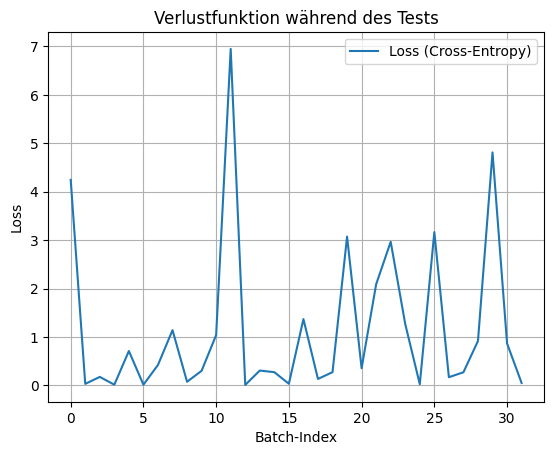

Accuracy (SNN): 92.80%
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       0.94      0.92      0.93        85
           1       0.98      0.94      0.96       126
           2       0.95      0.95      0.95       116
           3       0.95      0.90      0.92       107
           4       0.96      0.90      0.93       110
           5       0.87      0.95      0.91        87
           6       0.93      0.97      0.95        87
           7       0.95      0.93      0.94        99
           8       0.89      0.89      0.89        89
           9       0.84      0.94      0.88        94

    accuracy                           0.93      1000
   macro avg       0.93      0.93      0.93      1000
weighted avg       0.93      0.93      0.93      1000



In [ ]:
from sklearn.metrics import classification_report
import numpy as np
from matplotlib import pyplot as plt
from scipy.stats import f_oneway

snn_model.eval()
correct = 0
total = 0
loss_values = []

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.view(images.size(0), -1).to(device)
        spikes = image_to_spikes(images, time_steps).to(device)

        outputs = snn_model(spikes)
        loss = snn_loss_fn(outputs, labels.to(device))
        loss_values.append(loss.item())

        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels.to(device)).sum().item()

        # Wichtig: Auf CPU bringen und zu Listen hinzufügen
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

# Accuracy berechnen
accuracy = 100 * correct / total
print(f'Accuracy (SNN): {accuracy:.2f}%')

# Optional: target names, z. B. für KMNIST (0–9)
class_names = [str(i) for i in range(10)]

# Classification Report
report = classification_report(
    all_labels,
    all_preds,
    target_names=class_names,
    zero_division=0
)

f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)


10. CNN Evaluieren

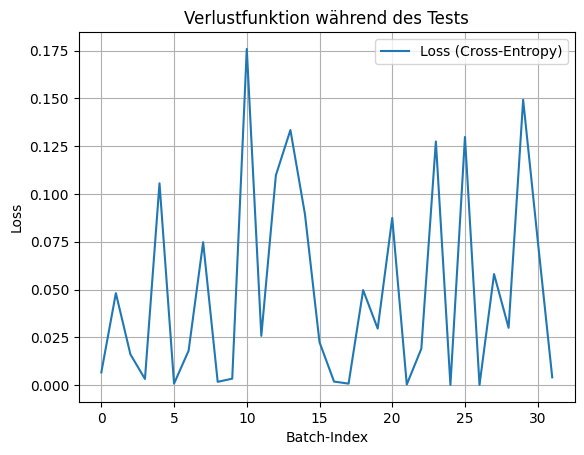

Accuracy (CNN): 98.40%
Precision (macro): 0.9832
Recall (macro):    0.9837
F1-Score (macro):  0.9834
F = 0.000, p = 1.000
              precision    recall  f1-score   support

           0       0.98      1.00      0.99        85
           1       1.00      0.99      1.00       126
           2       0.98      0.98      0.98       116
           3       0.99      0.99      0.99       107
           4       0.99      0.98      0.99       110
           5       0.98      0.99      0.98        87
           6       1.00      0.98      0.99        87
           7       0.99      1.00      0.99        99
           8       0.95      0.98      0.96        89
           9       0.98      0.95      0.96        94

    accuracy                           0.98      1000
   macro avg       0.98      0.98      0.98      1000
weighted avg       0.98      0.98      0.98      1000



In [ ]:
from sklearn.metrics import precision_score, recall_score, f1_score, classification_report
from matplotlib import pyplot as plt

loss_values = []
cnn_model.eval()
correct = 0
total = 0

all_preds = []
all_labels = []

with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        labels = labels.to(device)
        
        outputs = cnn_model(images)
        loss = cnn_loss_fn(outputs, labels)
        loss_values.append(loss.item())
    
        _, predicted = torch.max(outputs, 1)

        total += labels.size(0)
        correct += (predicted == labels).sum().item()

        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

# Plot der Verlustkurve
plt.plot(loss_values, label="Loss (Cross-Entropy)")
plt.xlabel("Batch-Index")
plt.ylabel("Loss")
plt.title("Verlustfunktion während des Tests")
plt.legend()
plt.grid(True)
plt.show()

precision = precision_score(all_labels, all_preds, average='macro')
recall = recall_score(all_labels, all_preds, average='macro')
f1 = f1_score(all_labels, all_preds, average='macro')

print(f'Accuracy (CNN): {100 * correct / total:.2f}%')
print(f'Precision (macro): {precision:.4f}')
print(f'Recall (macro):    {recall:.4f}')
print(f'F1-Score (macro):  {f1:.4f}')

report = classification_report(all_labels, all_preds, zero_division=0)
f_stat, p_val = f_oneway(all_labels, all_labels)
print(f"F = {f_stat:.3f}, p = {p_val:.3f}")
print(report)
